In [390]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import random

In [391]:
# Dictionary storing the hop counts of mesh nodes
hop_count_values = {}
node_to_parent = {}

# Convert string representation of topology to a dictionary of lists (adjacency list) that can be parsed by networkX
def topology_to_graph(topology):
    
    graph = {}
    mesh_nodes = topology.split("\n")
    mesh_nodes = [node for node in mesh_nodes if node]
    last_hop = 0
    parent_node = None
    node_hops = []

    for node in mesh_nodes:
        
        hop_count = len(node) - len(node.lstrip())
        node_number = int(node.lstrip())
        node_hops.append((node_number, hop_count))
        graph[node_number] = []
        hop_count_values[node_number] = {}
        hop_count_values[node_number] = hop_count

        if not parent_node:
            parent_node = node_number
            node_to_parent[node_number] = parent_node
            continue

        if hop_count <= last_hop:
            previous_hops = [(number, hop) for (number, hop) in node_hops if hop == hop_count-1]
            parent_node = previous_hops[-1][0]
            
        graph[parent_node].append(node_number)
        node_to_parent[node_number] = parent_node
        parent_node = node_number
        last_hop = hop_count

    return graph

In [392]:
# Example topology to test networkX features. The number of spaces represent the number of hops 
# (since 26 is preceeded by 3 spaces, it is 3 hops away from the controller)
# Similarily, 29 has no spaces before it - therefore, it is the controller which is at 0 hops
top1 = """
29
 27
  28
   26
 33
  34
  37
"""

network = topology_to_graph(top1)
network

{29: [27, 33], 27: [28], 28: [26], 26: [], 33: [34, 37], 34: [], 37: []}

In [393]:
network_graph = nx.DiGraph(network)

In [394]:
network = nx.to_dict_of_lists(network_graph)

In [395]:
# Create 2D matrix of rssi values where rssi_weights[nodeA][nodeB] = rssi connection between Node A & Node B

max_nodes = 100
rssi_weights = [[0 for i in range(max_nodes)] for j in range(max_nodes)]
node_list = list(nx.nodes(network_graph))

# Example function (not accurate)
def getRSSI(nodeA, nodeB):
    return -1 * (node_list[nodeA]+ node_list[nodeB])
    # return random.randint(-80, -50)


for node_row_index in range(len(rssi_weights)):
    for node_col_index in range(node_row_index, len(rssi_weights), 1):
        rssi_weights[node_row_index][node_col_index] = rssi_weights[node_col_index][node_row_index] = random.randint(-80, -50)

# for node_row_index in range(len(node_list)):
#     for node_col_index in range(node_row_index , len(node_list), 1):
#         rssi_weights[node_list[node_row_index]][node_list[node_col_index]] = rssi_weights[node_list[node_col_index]][node_list[node_row_index]] = getRSSI(node_row_index, node_col_index)

In [396]:
print(list(network_graph.successors(37)))

[]


In [397]:
# Assign Tree weight: Number of nodes behind and including the current mesh node.  
# For instance, a mesh AP with 3 nodes behind it (whether directly connected or in daisy-chain) has a weight of 4.  
# A mesh AP with no nodes behind it has a weight of 1.

tree_weights = {}
def set_tree_weight(graph, node = 29):
    tree_weights[node] = 1
    for child_node in list(graph.successors(node)):
        set_tree_weight(graph, child_node)
        tree_weights[node] += tree_weights[child_node]
    graph.nodes[node]['weight'] = tree_weights[node]

def get_root(graph):
    return [n for n,d in graph.in_degree() if d==0][0] 

def set_node_hops(graph, node = 29, hop_count = 0):
    graph.nodes[node]['hop_count'] = hop_count
    for child_node in list(graph.successors(node)):
        set_node_hops(graph, child_node, hop_count + 1)

def set_rssi_values(graph):
    for edge in graph.edges():
        graph.edges[edge]["rssi"] = rssi_weights[edge[0]][edge[1]]
    

set_tree_weight(network_graph)
set_node_hops(network_graph)
set_rssi_values(network_graph)


In [398]:
def print_nodes(graph):
    print("Nodes:")
    node_data = graph.nodes(data = True)
    for (node, data) in node_data:
        print(node, data)

def print_edges(graph):
    print("Edges:")
    edge_data = graph.edges(data = True)
    for (node1, node2, data) in edge_data:
        print("({}, {})".format(node1, node2), data)

def print_graph_attributes(graph):
    print_nodes(graph)
    print()
    print_edges(graph)

In [399]:
print_graph_attributes(network_graph)

Nodes:
29 {'weight': 7, 'hop_count': 0}
27 {'weight': 3, 'hop_count': 1}
28 {'weight': 2, 'hop_count': 2}
26 {'weight': 1, 'hop_count': 3}
33 {'weight': 3, 'hop_count': 1}
34 {'weight': 1, 'hop_count': 2}
37 {'weight': 1, 'hop_count': 2}

Edges:
(29, 27) {'rssi': -65}
(29, 33) {'rssi': -74}
(27, 28) {'rssi': -80}
(28, 26) {'rssi': -62}
(33, 34) {'rssi': -75}
(33, 37) {'rssi': -54}


In [400]:
def draw_network(graph, path):
    # Determine edges less than and greater than rssi_threshold
    rssi_threshold_weak = -70
    rssi_threshold_strong = -60

    edge_colors = ["k", "tab:orange", "tab:red"]
    
    elarge = [(u, v) for (u, v, d) in graph.edges(data=True) if d["rssi"] > rssi_threshold_strong]
    emid = [(u, v) for (u, v, d) in graph.edges(data=True) if rssi_threshold_weak < d["rssi"] <= rssi_threshold_strong]
    esmall = [(u, v) for (u, v, d) in graph.edges(data=True) if d["rssi"] <= rssi_threshold_weak]


    # Get node to hop count dictionary
    
    node_to_hop = {n : d['hop_count'] for n, d in graph.nodes(data=True)}

    # Normalize hop count values and use color map to visualize hop count distances in output
    low, *_, high = sorted(node_to_hop.values())
    norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)

    pos = graphviz_layout(graph, prog='dot')
    fig = plt.figure(1, figsize=(8, 6), dpi = 120)

    # Draw Nodes
    nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color=[mapper.to_rgba(i) 
                        for i in node_to_hop.values()], edgecolors = 'k')

    # Draw Edges
    nx.draw_networkx_edges(graph, pos, edgelist=elarge, width=5, edge_color=edge_colors[0], arrowstyle='-')

    nx.draw_networkx_edges(graph, pos, edgelist=emid, width=5, alpha=0.5, edge_color=edge_colors[1], arrowstyle='-')

    nx.draw_networkx_edges(graph, pos, edgelist=esmall, width=5, alpha=0.5, edge_color=edge_colors[2], arrowstyle='-')

    # node labels
    nx.draw_networkx_labels(graph, pos, font_color='k')
    # edge weight labels
    edge_labels = nx.get_edge_attributes(graph, "rssi")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)


    # ax = plt.gca()
    # ax.set_title("Topology 1")
    # # plt.figure(figsize=(30, 30))
    # # plt.axis("off")
    # plt.tight_layout()
    # plt.show()
    if path:
        plt.savefig(path)

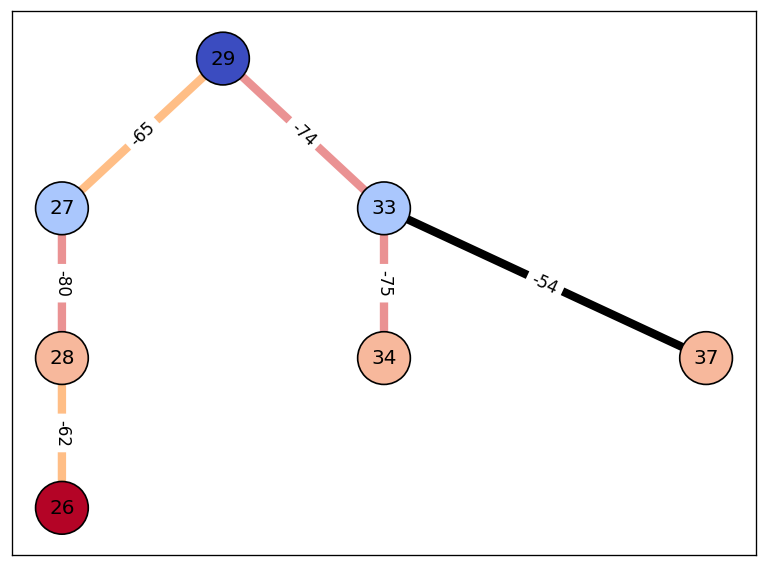

In [401]:
draw_network(network_graph, "initialTop.png")

In [402]:
print(list(network_graph.predecessors(37))[0])

33


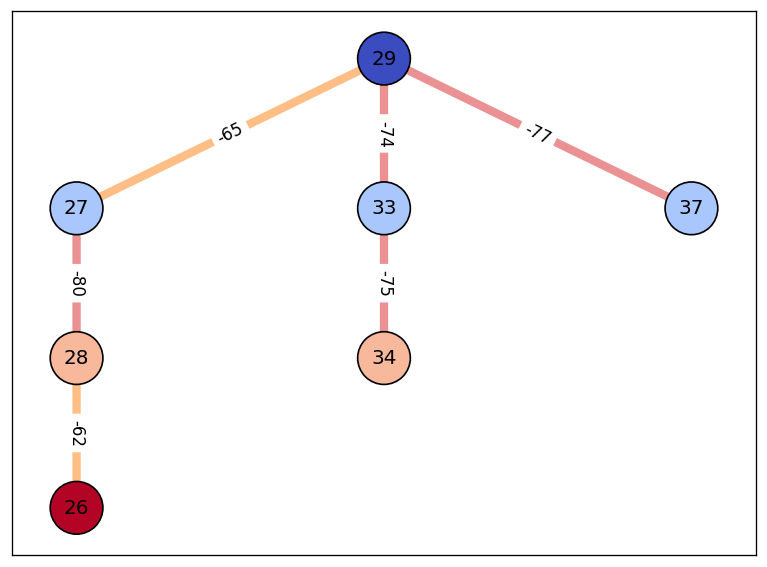

In [403]:
# Identify weak connections and nodes to reposition
# Test removing and adding node/edge

# Move node 37 to be directly behind controller
def move_node(graph, node, new_parent):

    graph.remove_node(node)
    graph.add_edge(new_parent, node, rssi = rssi_weights[new_parent][node])

    set_node_hops(graph, get_root(graph))
    set_tree_weight(graph, get_root(graph))


move_node(network_graph, 37, 29)
draw_network(network_graph, "top_move_node.png")


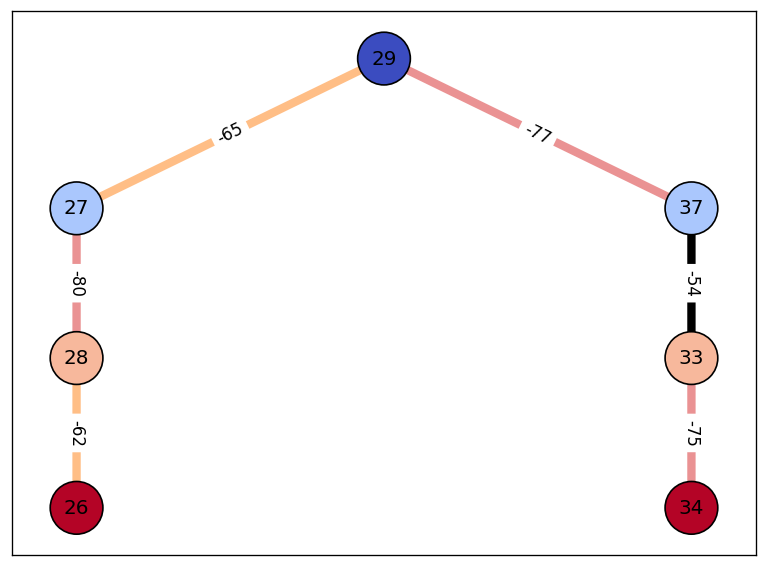

In [404]:
# Test removing and adding multiple single node/edge
# Move nodes 33, 34 behind 37

def move_tree(graph, node, new_parent):

    child_nodes = list(graph.successors(node))
    move_node(graph, node, new_parent)
    for child_node in child_nodes:
        move_tree(graph, child_node, node)
        

move_tree(network_graph, 33, 37)
draw_network(network_graph, "top_move_tree.png")

    

In [405]:
# Add node to network based on rssi value
def add_node(graph, node):

    # Scan each mesh node and add connection with best rssi value
    best_node = node
    best_rssi = -1000

    for n in graph.nodes:
        if rssi_weights[n][node] > best_rssi:
            best_rssi = rssi_weights[n][node]
            best_node = n

    graph.add_edge(best_node, node, rssi = best_rssi)
    
    set_node_hops(graph, get_root(graph))
    set_tree_weight(graph, get_root(graph))
    
    

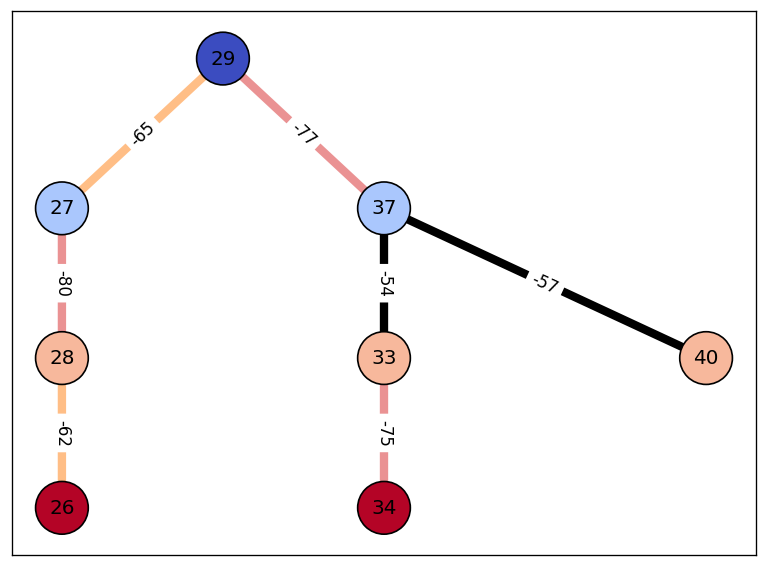

In [406]:
add_node(network_graph, 40)
draw_network(network_graph, "top_add_node.png")

In [407]:
# Score considers hop count at the BSSID, tree weight at the BSSID, 
# RSSI of the BSSID, and worst RSSI of the upstream path

# BSSID is the existing device while node is the node to add
def get_score(graph, node, BSSID):

    # Get hop count
    hop_count = graph.nodes[BSSID]['hop_count'] + 1
    # Get tree weight
    tree_weight = graph.nodes[BSSID]['weight']
    # Get RSSI 
    rssi = rssi_weights[BSSID][node]
    
    # Fine worst RSSI of the upstream path
    worst_rssi = 0

    if len(list(nx.all_simple_edge_paths(graph, BSSID, node))) > 0:
        path_to_bssid = list(nx.all_simple_edge_paths(graph, BSSID, node))[0]
        for edge in path_to_bssid:
            worst_rssi = min(worst_rssi, graph.edges[edge]['rssi'])
    else:
        worst_rssi = rssi

    print(hop_count, tree_weight, rssi, worst_rssi)
    
    # Calculate score: 
    return (rssi) * (hop_count) + (worst_rssi - tree_weight) - (hop_count * tree_weight)
    

    

In [408]:
def ap_optimization(graph, node, target_node = None):

    # Best BSSID defaults to current BSSID the mesh AP is connected to 
    best_bssid = list(graph.predecessors(node))[0]
    best_bssid_score = -100000
    hop_count_limit = 6
    threshold_rssi = -80
    hop_count = graph.nodes[node]["hop_count"]
    optimize_topology = False

    possible_nodes = graph.nodes
    # Controller goes through each 11k BSSID in the 11k results and establishes the best BSSID
    for bssid in graph.nodes:

        bssid_hop_count = graph.nodes[bssid]["hop_count"]

        # If RSSI < cut-off RSSI discard this BSSID as a potential candidate 
        # If BSSID is behind this mesh AP discard this BSSID as a potential candidate 
        if rssi_weights[node][bssid] < threshold_rssi or bssid_hop_count > hop_count:
            continue

        # If a target mesh AP is provided to the function – and if the BSSID is the not the target mesh AP 
        # or a child of the target mesh AP discard this BSSID as a potential candidate 
        if target_node:
            if bssid != target_node or bssid not in graph.successors(target_node):
                continue
            
        # If a hop-count limit is configured and this BSSID has a hop-count >= hop-count limit 
        # then discard this BSSID as a potential candidate 
        if bssid_hop_count >= hop_count_limit:
            continue

        # Create a score for this BSSID 
        bssid_score = get_score(graph, node, bssid)

        # If the score of this BSSID > score best BSSID 
        if bssid_score >= best_bssid_score:
            best_bssid_score = bssid_score
            best_bssid = bssid
            optimize_topology = True
    
    if optimize_topology:
        # print(node, best_bssid)
        move_tree(graph, node, best_bssid)
    

def low_rssi_optimization(graph, threshold = -70):

    # Sort the APs below the RSSI threshold to handle the lowest RSSI APs first
    weak_edges = [(u, v, d["rssi"]) for (u, v, d) in graph.edges(data=True) if d["rssi"] < threshold]
    sorted_weak_edges = sorted(weak_edges, key=lambda data: data[2])
    nodes_to_optimize = [data[1] for data in sorted_weak_edges]

    # Iterate through each low RSSI AP 
    for node in nodes_to_optimize:
        # Call Function to handle individual mesh AP optimization for AP 
        ap_optimization(node)

def tree_rebalance(graph, R = 5, S = 0.1):
    # Recalculate all tree weights 
    set_tree_weight()
    
    node_hops = [(data['hop_count'], node) for (node, data) in graph.nodes(data = True)]
    hop_to_nodes = {}
    for x, y in node_hops:
        hop_to_nodes.setdefault(x, []).append(y)

    rebalance_from = []
    rebalance_to = []

    # Iterate through all hop levels 
    for hop_count in list(hop_to_nodes.keys())[1:]:
        # Iterate through all APs at the given hop level 
        for node in hop_to_nodes[hop_count]:
            # If this AP’s weight is more R (R or more nodes connected behind this AP where R >= 5) 
            node_weight = graph.nodes[node]['weight']
            if node_weight > R:
                # If this AP’s weight is S% lower than another AP at this hop level 
                if any(node_weight < (1 - S) * [graph.nodes[n]['weight'] for n in hop_to_nodes[hop_count] if n != node]):
                    rebalance_to.append(node)
                    rebalance_from.extend([n for n in hop_to_nodes[hop_count] if n != node and node_weight < (1 - S) * graph.nodes[n]['weight']])  

    # Iterate through all APs in the from list
    for node in rebalance_from:
        # Get a list of all of the APs connected mesh nodes and sort by weight from lowest to highest
        connected_mesh_nodes = [(n, data['weight']) for (n, data) in graph.nodes(data = True) if n in network[node]]
        sorted_connected_mesh_nodes = [node for (node, weight) in sorted(connected_mesh_nodes, key = lambda data: data[1])]
        for sorted_node in sorted_connected_mesh_nodes:
            # Call Function to handle individual mesh AP optimization for the given node with mesh AP in the target tree list 
            ap_optimization(sorted_node)


In [409]:
# Replicating scenerio described in Carrier prplMesh Topology Mechanism Document
# Scenerio Analysis with Algorithms:

# Controller with mesh nodes A, B, C, D, E, F 

mesh_nodes = [0, 'A', 'B', 'C', 'D', 'E', 'F']
rssi_weights = {}

for nodeA in mesh_nodes:
    rssi_weights[nodeA] = {}
    for nodeB in mesh_nodes:
        rssi_weights[nodeA][nodeB] = -100


In [410]:
# 1. Controller boots up the first time.  
# Creates backhaul credentials and turns on backhaul interface 

# Node 0 is Controller

def create_network_with_controller():
    top = nx.DiGraph()
    top.add_node(0)
    return top

top_graph = create_network_with_controller()
set_node_hops(top_graph, node = 0)
set_tree_weight(top_graph, node = 0)

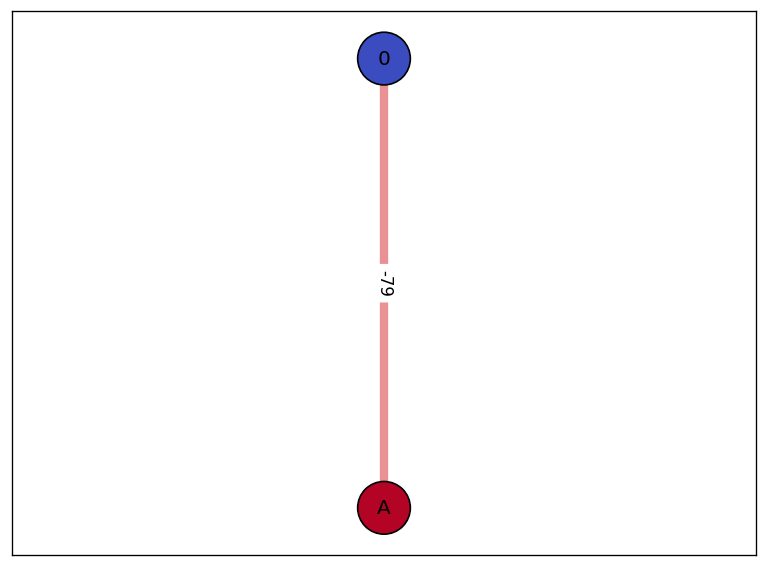

In [411]:
# 2. Mesh A node onboarding: 

# Mesh A to controller RSSI is -79 
rssi_weights['A'][0] = rssi_weights[0]['A'] = -79
# Mesh A joins controller 
add_node(top_graph, 'A')
# Controller kicks off low RSSI timer 
# Low RSSI node check runs – it checks Mesh A but no change is available 
# Tree rebalancing runs but no change is needed 
# After Mesh A onboarding, Mesh topology is: Controller <- -79 -> Mesh A 
draw_network(top_graph, '1_A_onboard')


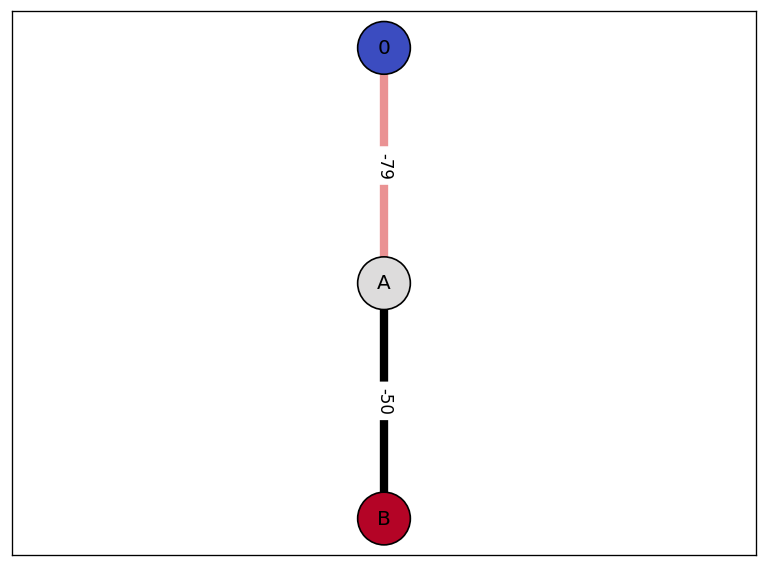

In [412]:
# 3. Mesh B node onboarding: 
# Mesh B to controller RSSI is -65 
rssi_weights['B'][0] = rssi_weights[0]['B'] = -65
# Mesh B to Mesh A RSSI is -50 
rssi_weights['B']['A'] = rssi_weights['A']['B'] = -50

# Mesh B joins Mesh A because RSSI is higher 

add_node(top_graph, 'B')
draw_network(top_graph, '2_B_onboard')

# Mesh B starts LAN discovery 
# Mesh A continues LAN discovery 


# After Mesh B onboarding, Mesh topology is: 
# Controller <- -79 -> Mesh A <- -50 -> Mesh B 

2 2 -50 -50
1 3 -65 -79
1 3 -65 -79
2 2 -50 -50


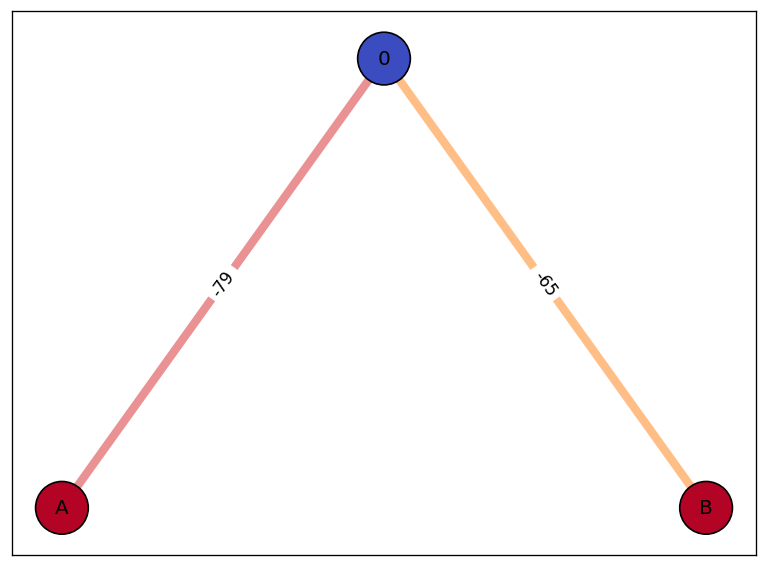

In [413]:
# Mesh B is optimized 

# Controller calculates score for Mesh B on Mesh A, Score is low because Mesh A RSSI is -79 
score_ba = get_score(top_graph, 'B', 'A')
# Controller calculates score for Mesh B on controller, Score is higher because fewer hops and RSSI is -65 
score_b0 = get_score(top_graph, 'B', 0)

# Controller moves Mesh B to controller 
ap_optimization(top_graph, 'B')
draw_network(top_graph, '3_B_optimized')

# After optimization of Mesh B, Mesh topology is: 
# Controller <- -79 -> Mesh A 
#            <- -65 -> Mesh B 

1 3 -79 -79
2 1 -50 -50
1 3 -79 -79
2 1 -50 -50


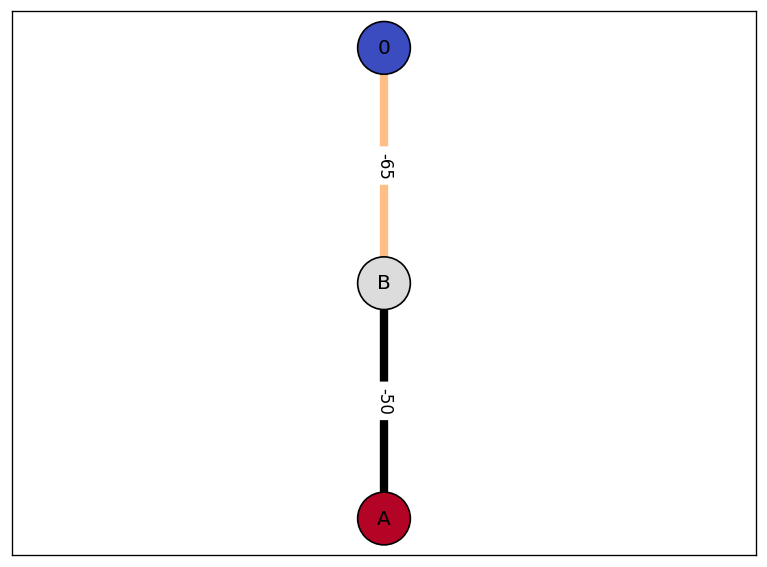

In [414]:
# Low RSSI node check runs – it checks Mesh A 
# Mesh A is optimized 

# Controller calculates score for Mesh A on controller, Score is low because Mesh A RSSI is -79 
get_score(top_graph, 'A', 0)
# Controller calculates score for Mesh A on Mesh B, Score is higher because Mesh A RSSI is -50 even though hops are lower 
get_score(top_graph, 'A', 'B')
# Controller moves Mesh A to Mesh B 

ap_optimization(top_graph, 'A')
draw_network(top_graph, '4_A_optimized')


# After low RSSI timer handles Mesh A, Mesh topology is: 
# Controller <- -65 -> Mesh B <- -50 -> Mesh A 

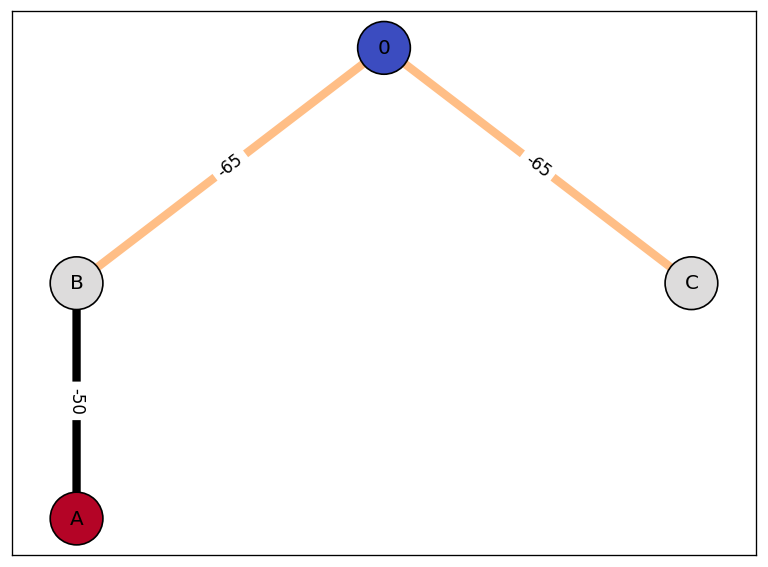

In [415]:
# 4. Mesh C node onboarding: 
# Mesh C to controller is -55 
rssi_weights['C'][0] = rssi_weights[0]['C'] = -55
# Mesh C to Mesh A is -85 
rssi_weights['C']['A'] = rssi_weights['A']['C'] = -85
# Mesh C to Mesh B is -65 
rssi_weights['C'][0] = rssi_weights[0]['C'] = -65

# Mesh C joins controller since RSSI is the highest 
add_node(top_graph, 'C')
draw_network(top_graph, '5_C_onboard')

# After Mesh C onboarding, Topology is: 
# Controller <- -65 -> Mesh B <- -50 -> Mesh A 
#            <- -55-> Mesh C 


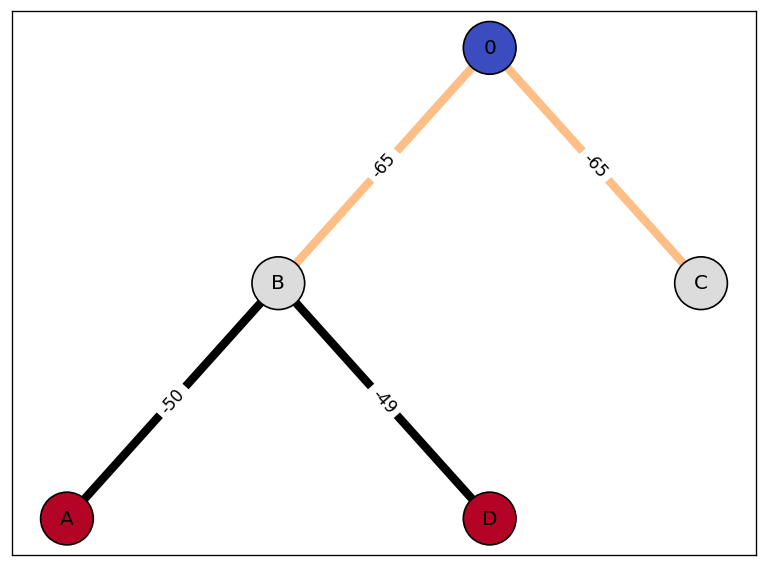

In [416]:
# 5. Mesh D node onboarding: 
# Mesh D to controller is -78 
rssi_weights['D'][0] = rssi_weights[0]['D'] = -78
# Mesh D to Mesh C is -50 
rssi_weights['D']['C'] = rssi_weights['C']['D'] = -50
# Mesh D to Mesh B is -49 
rssi_weights['D']['B'] = rssi_weights['B']['D'] = -49
# Mesh D to Mesh A is -65 
rssi_weights['D']['A'] = rssi_weights['A']['D'] = -78

# Mesh D joins Mesh B since the RSSI is the highest 
add_node(top_graph, 'D')
draw_network(top_graph, '6_D_onboard')

# After Mesh D onboarding, Topology is: 
# Controller <- -65 -> Mesh B <- -50 -> Mesh A 
#                             <- -49 -> Mesh D 

#            <- -55-> Mesh C 

1 5 -78 -65
2 3 -49 -49
3 1 -78 -78
2 1 -50 -50


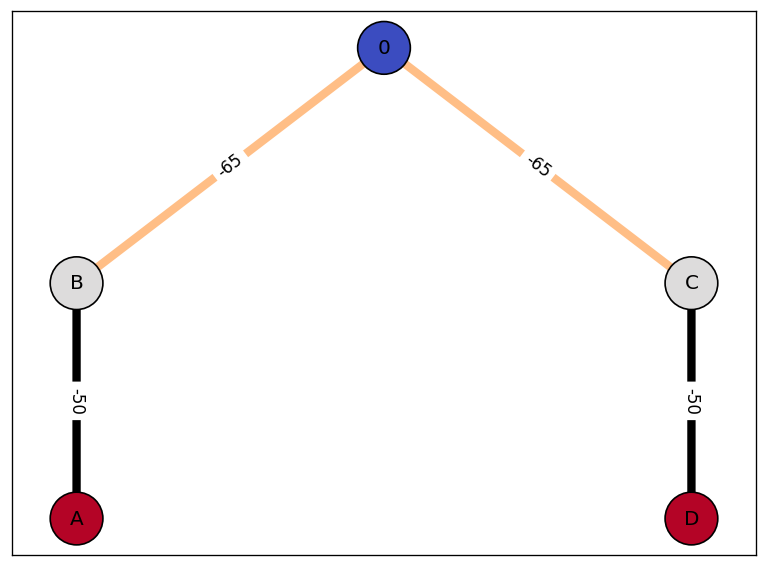

In [417]:
# Mesh D optimized 
# Mesh D is moved to Mesh C as the tree weight of Mesh C is lower 

ap_optimization(top_graph, 'D')
draw_network(top_graph, '7_D_optimize')

# After Mesh D optimization, Topology is: 
# Controller <- -65 -> Mesh B <- -50 -> Mesh A 
#            <- -55-> Mesh C <- -50 -> Mesh D 
